In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
import numpy as np
from time import time
import torch

from planet import PlaNet
from planet.data import PlaNetDataset

from planet.plot import contour, contourf

In [159]:
planet = PlaNet.from_pretrained('../trained_models/planet_physics_informed/')
planet.model

PlaNetCore(
  (trunk): TrunkNet(
    (norm_r): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (norm_z): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (trunk_r): ModuleList(
      (0): Sequential(
        (0): Conv2dNornAct(
          (conv2d): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): TrainableSwish()
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2dNornAct(
          (conv2d): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): TrainableSwish()
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): S

### Laod the dataset and perform a forward pass. 
Given a dataset with the same format of the one used for training (see `1_dataset_creation.ipynb`), you can use the `PlaNetDataset` class to open open it ad to compute the GS operator automatically using its `__getitem__` method. You need to specfy `nr` and `nz` (the grid sizes), that need to be the same specified during training.

In [160]:
# load the dataset
ds = PlaNetDataset(
    path='../planet/tests/data/iter_like_data_sample.h5',
    nr=planet.model.config.nr,
    nz=planet.model.config.nz
)
print(f'The dataset has {len(ds)=} items')


The dataset has len(ds)=64 items


In [161]:
import h5py

data = {}
with h5py.File('../planet/tests/data/iter_like_data_sample.h5', 'r') as f:
    for k,v in f.items():
        data[k] = v[()]

print(data.keys())

dict_keys(['RR_grid', 'ZZ_grid', 'coils_current', 'flux', 'measures', 'p_profile', 'rhs'])


We can compute the reconstructed flux map $\psi(r,z)$ and the GS operator $\Delta^*\psi(r,z)$ directly using the `planet` pipeline.

In [162]:
# call planet to predict the flux map. The pipeline will automatically scale the the input and return the flux map
idx_sample = 15
planet_inputs = {
    "measures":data['measures'][idx_sample, ...],
    "coils_current":data['coils_current'][idx_sample, ...],
    "profile":data['p_profile'][idx_sample, ...],
    "rr":data['RR_grid'],
    "zz":data['ZZ_grid'],
}
flux = planet(**planet_inputs)

gs_ope = planet.compute_gs_operator(
    flux=flux, 
    rr=data['RR_grid'],
    zz=data['ZZ_grid'],
)


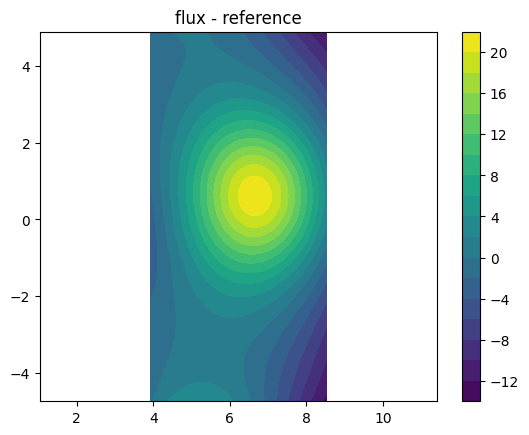

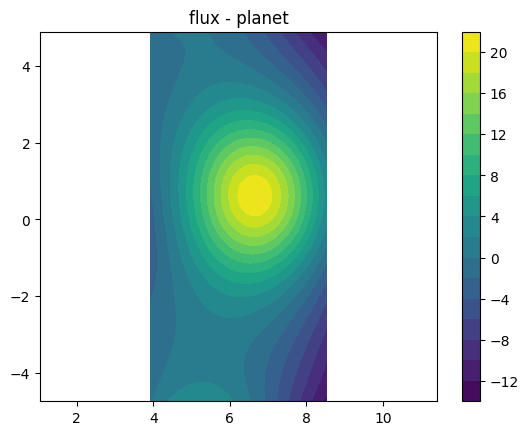

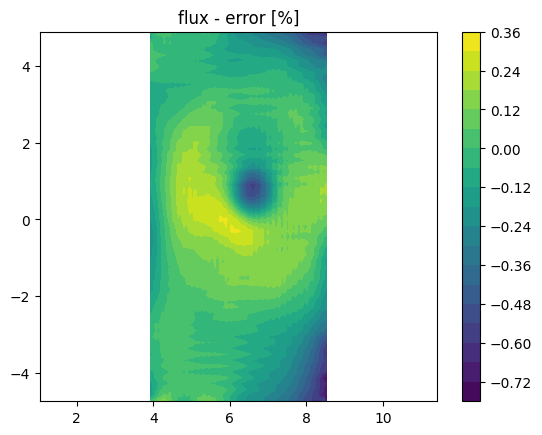

In [163]:
contourf(data['flux'][idx_sample, ...], data['RR_grid'], data['ZZ_grid'], title="flux - reference")
contourf(flux, data['RR_grid'], data['ZZ_grid'], title="flux - planet")

scale = np.abs(data['flux'][idx_sample, ...]).max()
contourf(
    100*(data['flux'][idx_sample, ...] - flux)/data['flux'][idx_sample, ...].max(), 
    data['RR_grid'], 
    data['ZZ_grid'], 
    title='flux - error [%]'
)

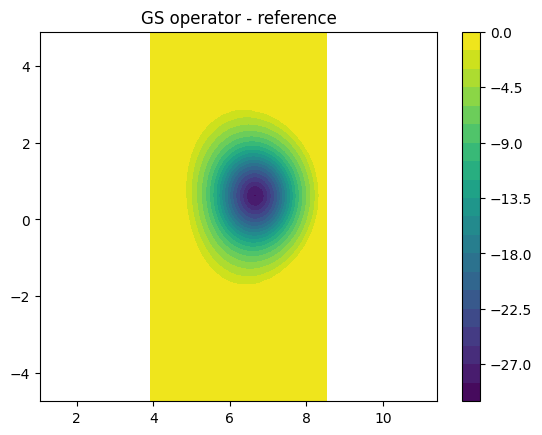

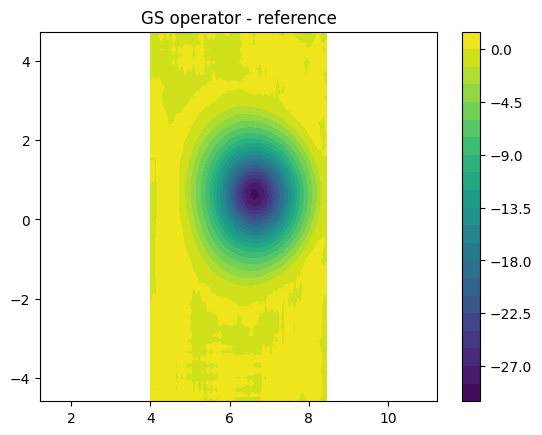

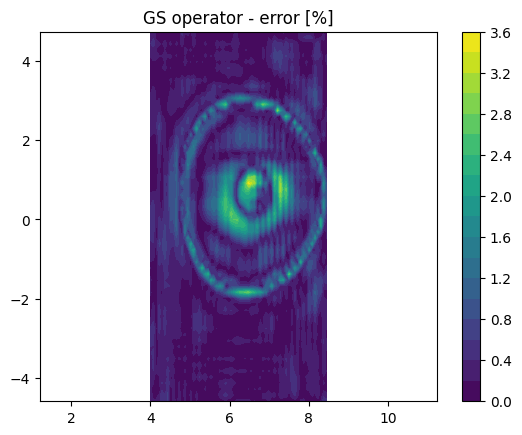

In [164]:
contourf(data['rhs'][idx_sample, ...], data['RR_grid'], data['ZZ_grid'], title="GS operator - reference")
contourf(gs_ope, data['RR_grid'][1:-1, 1:-1], data['ZZ_grid'][1:-1, 1:-1], title="GS operator - reference")

scale = np.abs(data['rhs'][idx_sample, ...]).max()
contourf(
    100*np.abs((data['rhs'][idx_sample, ...][1:-1, 1:-1] - gs_ope))/scale, 
    data['RR_grid'][1:-1, 1:-1], 
    data['ZZ_grid'][1:-1, 1:-1], 
    title='GS operator - error [%]'
)

### Inference time
We can test the inference time on a cpu and on a gpu. Expected runtime for a MacBook Pro with M1 Pro with 10-core CPU and 14-core GPU.

In [165]:
N_test = 1000

t_start = time()
for _ in range(N_test):
    flux = planet(**planet_inputs)
t_end = time() - t_start

print(f"Tipe per reconstruction: {t_end/N_test:3.3}s")

Tipe per reconstruction: 0.00443s


In [166]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

planet.model = planet.model.to(device)
planet.device = device

N_test = 1000

t_start = time()
for _ in range(N_test):
    flux = planet(**planet_inputs)
t_end = time() - t_start

print(f"Tipe per reconstruction: {t_end/N_test:3.3}s")


Tipe per reconstruction: 0.0073s
